# A baseline mock EoR signal simulation with $P(k) = A_0 k^{-2}$

Zachary Martinot and the HERA Validation Team

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-and-Metadata" data-toc-modified-id="Setup-and-Metadata-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup and Metadata</a></span><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Description" data-toc-modified-id="Description-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Software" data-toc-modified-id="Software-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Software</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#General-functions" data-toc-modified-id="General-functions-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>General functions</a></span></li></ul></li><li><span><a href="#hera_pspec-estimates-from-a-single-realization" data-toc-modified-id="hera_pspec-estimates-from-a-single-realization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><code>hera_pspec</code> estimates from a single realization</a></span></li><li><span><a href="#Comparison-to-input-power-spectrum" data-toc-modified-id="Comparison-to-input-power-spectrum-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison to input power spectrum</a></span></li><li><span><a href="#The-aliased-power-spectrum" data-toc-modified-id="The-aliased-power-spectrum-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The aliased power spectrum</a></span></li><li><span><a href="#More-realizations" data-toc-modified-id="More-realizations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>More realizations</a></span></li></ul></div>

## Setup and Metadata

### Abstract

The goal of this notebook is to show that the simplest `hera_pspec` estimator recovers the power spectrum from realistic visiblities in the most ideal case where the only source of emission on the sky is the cosmological signal and there are no systemic corruptions of the measured visibility.

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import h5py
import os

import hera_pspec as hps
import pyuvdata

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

Last executed: {{str(datetime.now())}}



- **Major Step Description:** Gaussian cosmological field with known $P(k)$ propagated to visibilities.
- **Minor Variation Description:** The input power spectrum is: $P(k) = A_0 k^{-2}$, with $A_0 =$ `1e1*(1./0.2)**-2.`. The simulated data is for an ideal 37-element HERA hex array, 8052 time samples over 1 sidereal day, 1024 frequency samples in 100-200MHz, and the antenna response given by the Fagnoni simulation of the HERA dipole-feed antenna.
- **Pipelines Tested:** `hera_pspec.pspec`
- **Criteria**:
  1. The estimates produced by `pspec` are consistent with a relative difference between $\langle \hat{P}(k) \rangle$ and the known power spectrum $P(k)$ that is $\leq 0.01$.

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}

{Brief notes on anything else interesting that was noted during testing}

### Software

HERA software used in this validation test, with associate git commit hash:

* `pyuvdata`: {{pyuvdata.version.git_hash}}
* `hera_pspec`: {{hps.version.git_hash}}

Versions of other software used in this validation test:

* `numpy`: {{np.version.full_version}}

### Data

The following paths reflect the exact locations of all data used in this test:

In [7]:
# Paths to multiple realizations
vis_data_path_base = '/lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_{0}.uvh5'
vis_data_paths = [vis_data_path_base.format(str(rel)) for rel in range(0,20)]

assert all([os.path.exists(path) for path in vis_data_paths])

In [8]:
# The fiducial realization
vis_data_path0 = vis_data_paths[0]

In [9]:
# Path to beam normalization data
omegas_data_path = '/lustre/aoc/projects/hera/Validation/HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
assert os.path.exists(omegas_data_path)

### General functions

In [10]:
# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_data(vis_data_path):
    uvd = pyuvdata.UVData()
    uvd.read_uvh5(vis_data_path)
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]
    
    VI_data = uvd.data_array[:,:,:,xx_ind] + uvd.data_array[:,:,:,yy_ind]
    
    uvd.select(polarizations=(-5))
    uvd.polarization_array[0] = 1
    uvd.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd

In [13]:
# This is the exact cosmological parameter in the input simulation
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hps.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                Om_b=Om_b,
                                                Om_c=Om_c,
                                                H0=H0,)
    return hps_cosmo

In [11]:
cosmo = astropyPlanck15_for_hera_pspec()
# cosmo = hps.conversions.Cosmo_Conversions()

## `hera_pspec` estimates from a single realization

In [18]:
# Load visibility data for the fiducial realiztion
%%time
uvdI = get_VI_data(vis_data_path0)

CPU times: user 15min 49s, sys: 17.4 s, total: 16min 6s
Wall time: 5min 15s


In [14]:
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hps.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                Om_b=Om_b,
                                                Om_c=Om_c,
                                                H0=H0,)
    return hps_cosmo

cosmo = astropyPlanck15_for_hera_pspec()

In [15]:
# Load beam data
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'].value
    Omegapp = h5f['Omegapp'].value

In [19]:
hpsb = hps.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, uvdI.freq_array[0], cosmo=cosmo)

In [20]:
# Convert visibility data from Jansky to milikelvin *at the source*
nu_e = 1420405751.7667 # Hz
nu_hz = uvdI.freq_array[0]

# conversion to mK at the observer
Jy_to_mK = hpsb.Jy_to_mK(nu_hz, pol='pI')

# conversion to mK at the source
Jy_to_mK_src = (nu_e/nu_hz) * Jy_to_mK

uvdI.data_array *= Jy_to_mK_src[None,None,:,None]

In [23]:
ds = hps.PSpecData(dsets=[uvdI, uvdI], wgts=[None,None], beam=hpsb)

ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

# 63 unique baselines
ant_pairs = [ant_pair for ant_pair in uvdI.get_antpairs() if ant_pair[0] != ant_pair[1]]

# 5 ~20MHz bandwidth spectral windows
edge_inds = [np.argmin(np.abs(nu_hz - nu_i)) for nu_i in 1e6*np.linspace(100.,200.,6, endpoint=True)]
spw_ranges = zip(edge_inds, edge_inds[1:])

In [24]:
%%time
uvp = ds.pspec(ant_pairs, ant_pairs, 
               dsets=(0,1),
               pols=('pI', 'pI'),
               spw_ranges=spw_ranges,
               input_data_weight='identity',
               norm='I',
               taper='blackman-harris',
               verbose=True,
               little_h=False)


Setting spectral range: (0, 205)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((3, 2), (3, 2))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((9, 0), (9, 0))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((9, 6), (9, 6))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((12, 6), (12, 6))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((13, 5), (13, 5))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((13, 6), (13, 6))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((13, 12), (13, 12))
pol: (1, 1)
  Building q_hat...
  Normalizin

  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 0), (36, 0))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 1), (36, 1))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 9), (36, 9))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 34), (36, 34))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (205, 409)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((3, 2), (3, 2))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((9, 0), (9, 0))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, 

  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((35, 5), (35, 5))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((35, 13), (35, 13))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((35, 23), (35, 23))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((35, 28), (35, 28))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 0), (36, 0))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 1), (36, 1))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 9), (36, 9))
pol: (1, 1)
  Building q_hat...
  Normalizing power s

  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((34, 9), (34, 9))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((34, 21), (34, 21))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((34, 26), (34, 26))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((35, 1), (35, 1))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((35, 5), (35, 5))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((35, 13), (35, 13))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((35, 23), (35, 23))
pol: (1, 1)
  Building q_hat...
  Normalizing power

  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((33, 1), (33, 1))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((33, 3), (33, 3))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((34, 0), (34, 0))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((34, 3), (34, 3))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((34, 8), (34, 8))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((34, 9), (34, 9))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((34, 21), (34, 21))
pol: (1, 1)
  Building q_hat...
  Normalizing power spect

  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((32, 0), (32, 0))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((32, 8), (32, 8))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((32, 9), (32, 9))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((32, 15), (32, 15))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((33, 1), (33, 1))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((33, 3), (33, 3))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((34, 0), (34, 0))
pol: (1, 1)
  Building q_hat...
  Normalizing power spect

In [26]:
blpair_group = [sorted(np.unique(uvp.blpair_array))]

uvp_avg = uvp.average_spectra(blpair_groups=blpair_group, time_avg=True, inplace=False)

uvp_avg.fold_spectra()

In [27]:
keys = uvp_avg.get_all_keys()

In [29]:
pspec_est, k_est, k_nyquist = {}, {}, {}

for spw in uvp_avg.data_array.keys():
    pspec_est[spw] = uvp_avg.get_data(keys[spw])[0]
    k_est[spw] = uvp_avg.get_kparas(spw, little_h=False)
    dly = uvp.get_dlys(spw)
    if dly.size % 2 == 0:
        tau_nyquist = np.amax(dly)
    else:
        ddly = np.diff(dly)[0]

        tau_nyquist = np.amax(dly) + ddly/2.
        
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))

    k_nyquist[spw] = np.amax(tau_nyquist)*uvp.cosmo.tau_to_kpara(z_mean, little_h=False)

## Comparison to input power spectrum

In [30]:
def true_power_spectrum(k):
    A0 = 1e1 * (1./0.2)**-2.
    Pk = 1e6*A0 * k**-2.
    return Pk

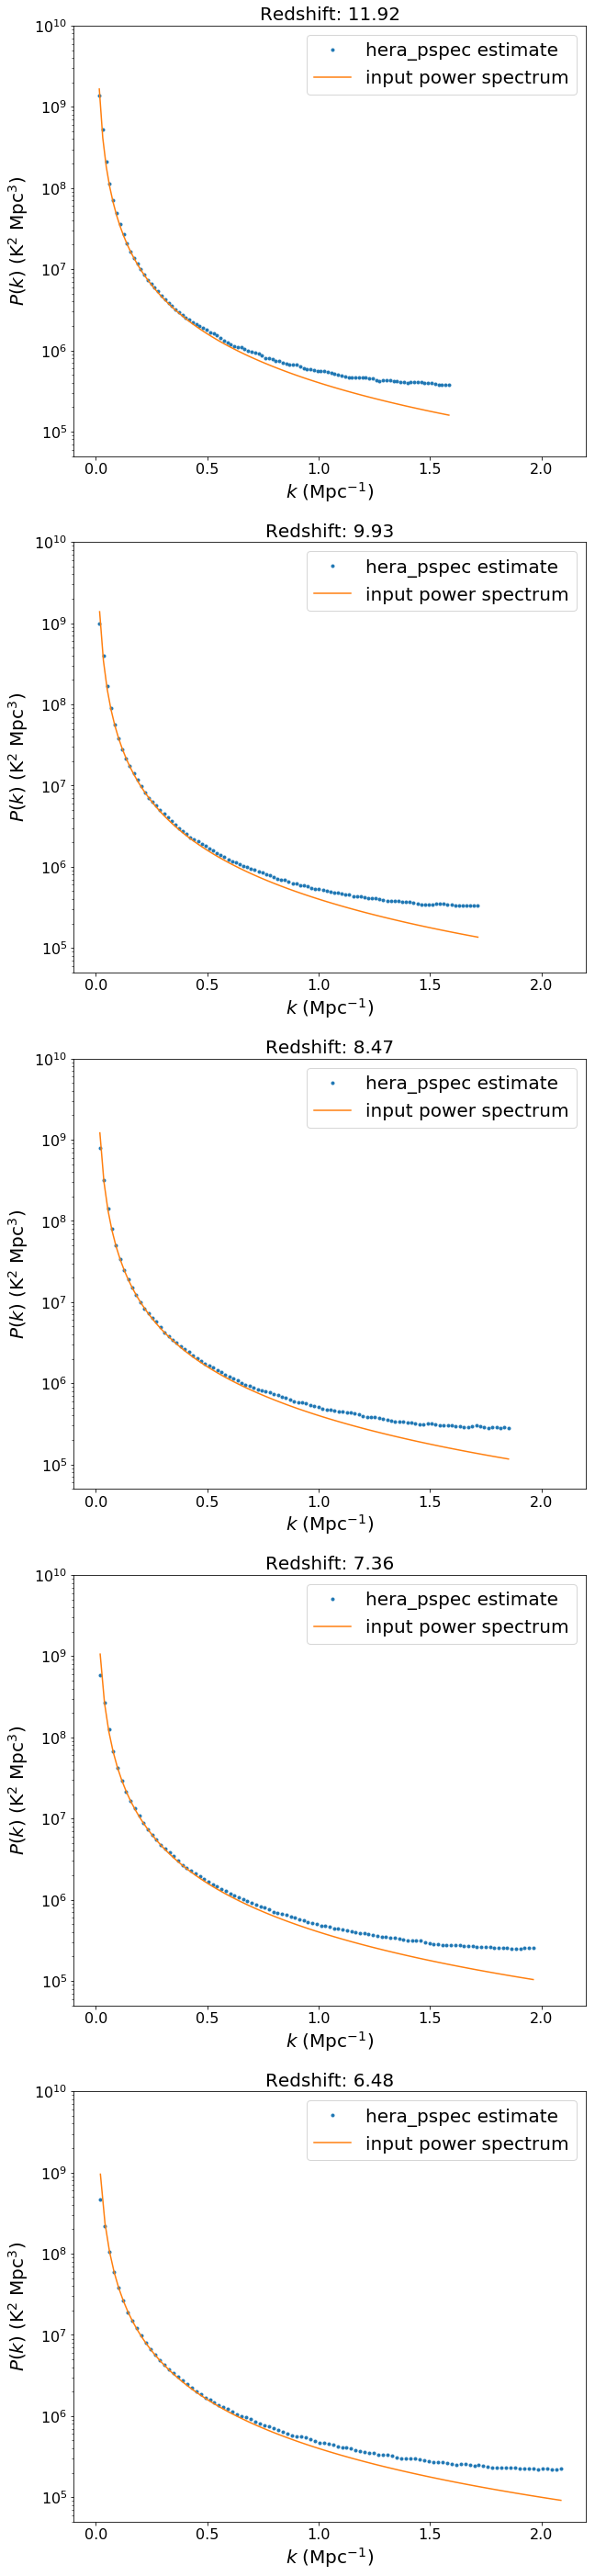

In [54]:
fig = plt.figure(figsize=(10,50))
for spw in pspec_est.keys():
    ax = fig.add_subplot(5,1,spw+1)
    ax.tick_params(labelsize=16)
    ax.plot(k_est[spw], pspec_est[spw], '.', label='hera_pspec estimate')
    ax.plot(k_est[spw], true_power_spectrum(k_est[spw]), label='input power spectrum')
    
    plt.yscale('log')
    plt.ylim(0.5e5,1e10)
    plt.xlim(-0.1,2.2)
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))
    
    plt.title(r'Redshift: {0}'.format(str(np.around(z_mean,2))), fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    plt.ylabel(r'$P(k)$ (K$^2$ Mpc$^3$)', fontsize=20)
    plt.legend(fontsize=20)
    
plt.show()

## The aliased power spectrum

The sampling induces aliasing, but we know exactly what it should be.

..

In [36]:
def aliased_power_spectrum(k, k_nyquist):
    A0 = 1e1 * (1./0.2)**-2.
    
    Pk = 1e6*A0 * (np.pi)**2. * 1./(2. * k_nyquist * np.sin(np.pi*k / k_nyquist /2.))**2.
    return Pk

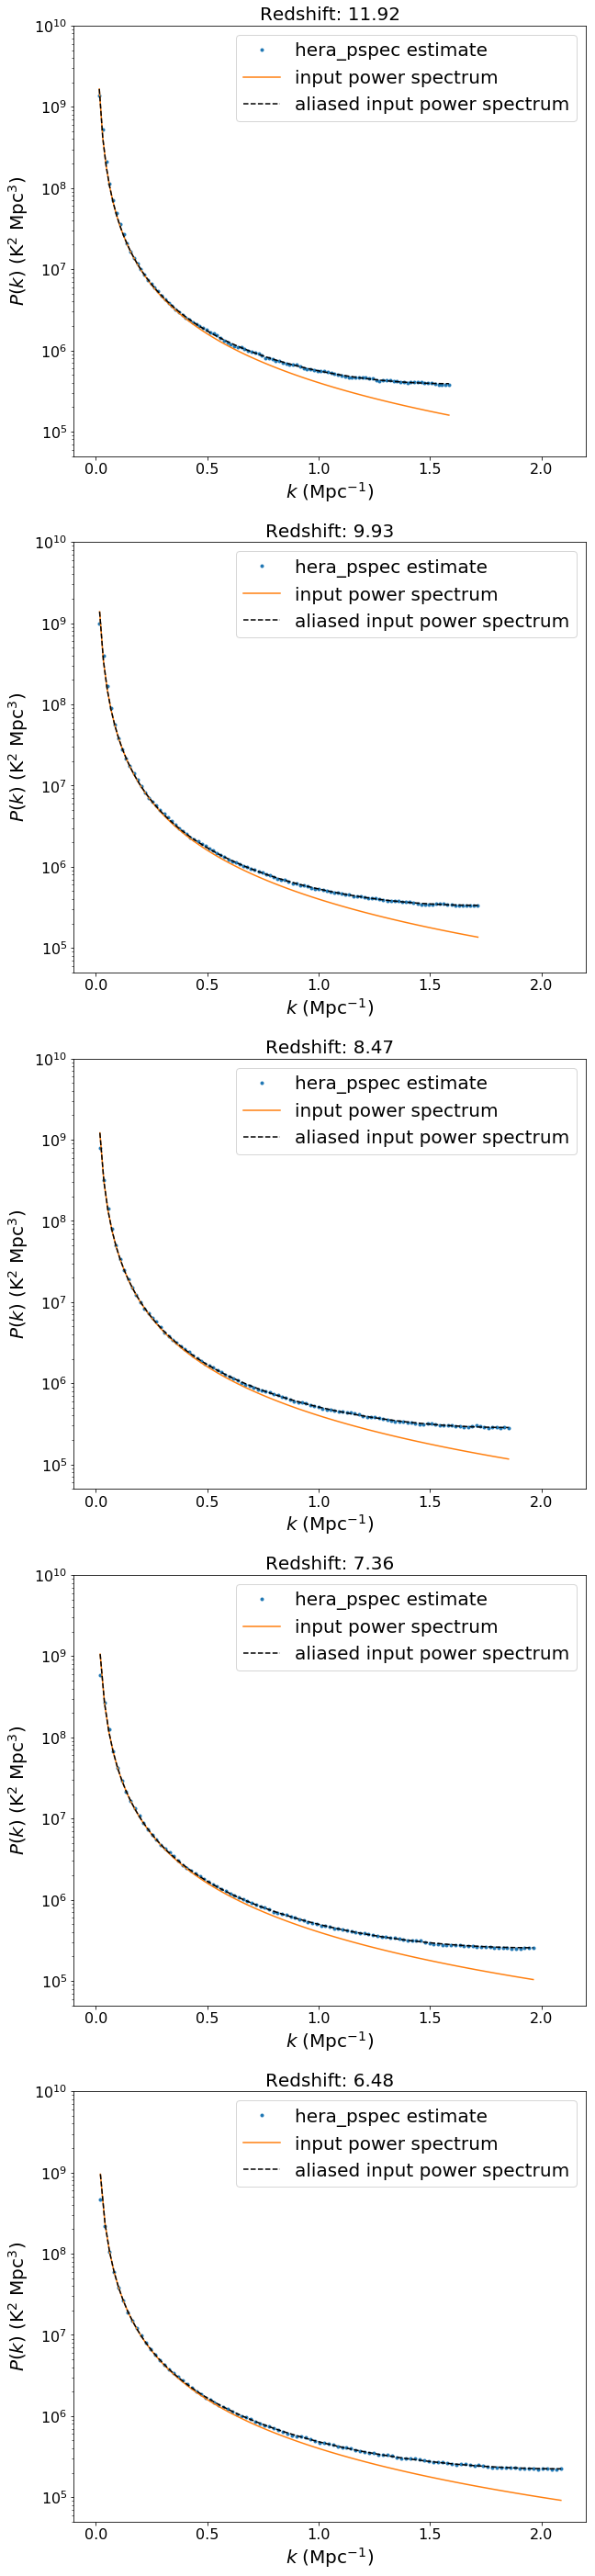

In [55]:
fig = plt.figure(figsize=(10,50))
for spw in pspec_est.keys():
    ax = fig.add_subplot(5,1,spw+1)
    ax.tick_params(labelsize=16)
    ax.plot(k_est[spw], pspec_est[spw], '.', label='hera_pspec estimate')
    ax.plot(k_est[spw], true_power_spectrum(k_est[spw]), label='input power spectrum')
    ax.plot(k_est[spw], aliased_power_spectrum(k_est[spw], k_nyquist[spw]), '--k', label='aliased input power spectrum')
    
    plt.yscale('log')
    plt.ylim(0.5e5,1e10)
    plt.xlim(-0.1,2.2)
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))
    
    plt.title(r'Redshift: {0}'.format(str(np.around(z_mean,2))), fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    plt.ylabel(r'$P(k)$ (K$^2$ Mpc$^3$)', fontsize=20)
    
    plt.legend(fontsize=20)
    
plt.show()

Evaluation of residuals

...

## More realizations